/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
45/45 [==============================] - 6s 84ms/step - loss: 0.0337
Epoch 2/100
45/45 [==============================] - 3s 67ms/step - loss: 0.0129
Epoch 3/100
45/45 [==============================] - 3s 66ms/step - loss: 0.0104
Epoch 4/100
45/45 [==============================] - 4s 93ms/step - loss: 0.0108
Epoch 5/100
45/45 [==============================] - 3s 65ms/step - loss: 0.0098
Epoch 6/100
45/45 [==============================] - 3s 66ms/step - loss: 0.0106
Epoch 7/100
45/45 [==============================] - 3s 65ms/step - loss: 0.0103
Epoch 8/100
45/45 [==============================] - 4s 91ms/step - loss: 0.0096
Epoch 9/100
45/45 [==============================] - 3s 65ms/step - loss: 0.0094
Epoch 10/100
45/45 [==============================] - 3s 67ms/step - loss: 0.0090
Epoch 11/100
45/45 [==============================] - 3s 68ms/step - loss: 0.0098
Epoch 12/100
45/45 [==============================] - 4s 88ms/step - loss: 0.0091
Epoch 13/100
45/45 [=====

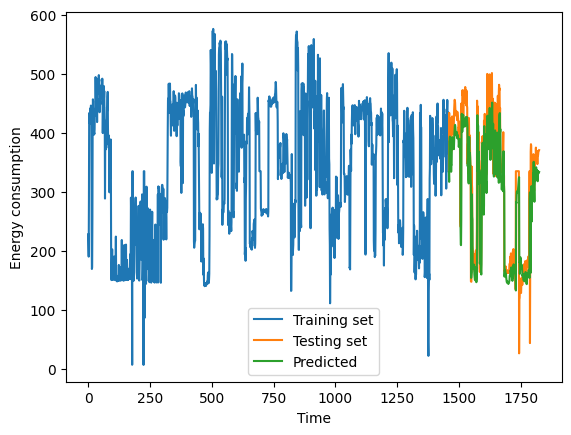

In [83]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization
from keras.optimizers import Adam

# 加载数据
data = pd.read_excel('./energy.xls', sheet_name='Sheet2')
# 根据时间排序
data = data.sort_values(by='date')
# 将 date 列转换成 Datetime 类型，并将其设置为索引列
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# 计算去零后的均值
mean_value = data.loc[data['value'] != 0, 'value'].mean()
# 将 0 替换为去零后的均值
data['value'] = data['value'].replace(0, mean_value)

# 划分训练集和测试集
num_train = int(len(data)*0.8)
train_set = data.iloc[:num_train, 0:1].values
test_set = data.iloc[num_train:, 0:1].values

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
train_set_scaled = scaler.fit_transform(train_set)

# 创建训练集数据和标签
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# look_back = 10
look_back = 20
X_train, y_train = create_dataset(train_set_scaled, look_back)

# 调整输入数据的形状
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# # 创建LSTM模型
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],
#                                                               X_train.shape[2])))
# model.add(LSTM(units=50))
# model.add(Dense(units=1))
# model.compile(optimizer='adam', loss='mean_squared_error')

#优化1.0，添加网络层和计算单元数量
# 创建LSTM模型
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],
                                                             X_train.shape[2]), 
               activation='relu'))
model.add(BatchNormalization())
model.add(LSTM(units=32, activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')


# 训练模型
model.fit(X_train, y_train, epochs=100, batch_size=32)



# 进行预测
inputs = data[len(data) - len(test_set) - look_back:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
X_test = []
for i in range(look_back, len(inputs)):
    X_test.append(inputs[i-look_back:i, 0])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)

# 将预测数据裁剪为与测试数据相同大小的形状
predicted = predicted[-len(test_set):]

# 绘制预测结果
train_set_plot = np.empty_like(data)
train_set_plot[:, :] = np.nan
train_set_plot[:num_train, :] = train_set

test_set_plot = np.empty_like(data)
test_set_plot[:, :] = np.nan
test_set_plot[num_train:, :] = test_set

predicted_plot = np.empty_like(data)
predicted_plot[:, :] = np.nan
predicted_plot[len(data)-len(test_set):, :] = predicted

plt.plot(train_set_plot, label='Training set')
plt.plot(test_set_plot, label='Testing set')
plt.plot(predicted_plot, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Energy consumption')
plt.legend()
plt.show()



In [29]:
print(len(train_set))#用1460天的数据去训练模型

1460


In [30]:
len(test_set)#剩下的366天作为测试集，比对模型预测的结果和真实的结果

366

11/11 [==============================] - 0s 7ms/step
RMSE value on test set: 153.32668983145206


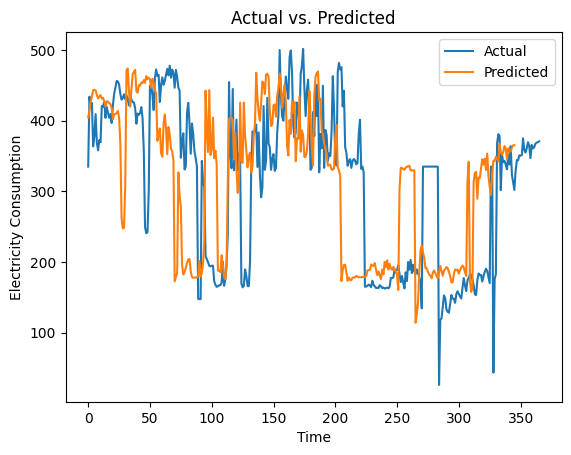

In [31]:
# 在测试集上进行预测
test_inputs = data.iloc[num_train+look_back:, 0:1].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

X_test = []
for i in range(look_back, len(test_inputs)):
    X_test.append(test_inputs[i-look_back:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)

# 裁剪预测数据与测试数据集的维度相同
test_set_reshaped = test_set.reshape(len(test_set))
predicted = predicted[:len(test_set_reshaped)]

# 计算 RMSE 值以评估模型性能
rmse = np.sqrt(np.mean(np.power((test_set_reshaped - predicted),2)))
print('RMSE value on test set:', rmse)
# 可视化真实值和预测值的对比
plt.plot(test_set, label='Actual')
plt.plot(predicted, label='Predicted')
plt.title('Actual vs. Predicted')
plt.xlabel('Time')
plt.ylabel('Electricity Consumption')
plt.legend()
plt.show()


模型的预测结果存在滞后性，则可以尝试以下几种方法来改进：

增加 look_back 值：增加 look_back 值可以增加模型的记忆长度，在一定程度上可以减少滞后性。但是，look_back 值过大也可能导致模型过拟合。
增加 LSTM 的单元数量：增加 LSTM 的单元数量可以增加模型的复杂度，进而提高模型的记忆能力。但是，增加单元数量也会增加模型的训练时间和计算成本。
增加训练集数量：增加训练集数量可以提高模型的泛化能力，进而减少滞后性。但是，找到更多的数据不一定是容易的。
增加其他变量：增加其他与能源消耗量相关的变量，如天气数据等，可以提高模型的预测准确性，减少滞后性。在这种情况下，需要使用多变量 LSTM 模型。

45/45 [==============================] - 1s 19ms/step
1439
[[416.834  ]
 [431.4981 ]
 [403.01395]
 ...
 [363.50745]
 [389.84348]
 [388.27106]]


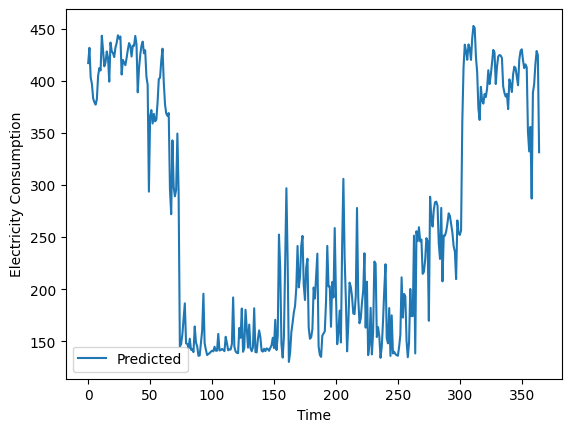

In [84]:
predicted = model.predict(X_train)
predicted = scaler.inverse_transform(predicted)
print(len(predicted))
print(predicted)
plt.plot(predicted[:365], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Electricity Consumption')
plt.legend()
plt.show()

1/1 [==============================] - 0s 29ms/step


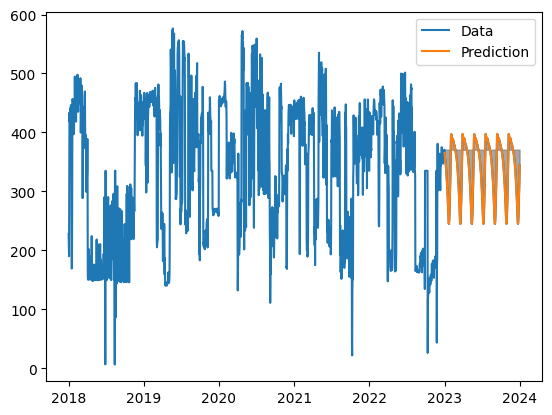

In [42]:
periods = 365  # 需要预测的时间段

# 构造 X_test
inputs = data.values
inputs = scaler.transform(inputs)
X_test = []
for i in range(len(inputs)-look_back, len(inputs)):
    X_test.append(inputs[i-look_back:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 循环预测并添加结果到 predicted 数组中
predicted = []
for i in range(periods):
    # 预测一个步长
    prediction = model.predict(X_test[-1:])
    # 添加到结果数组
    predicted.append(prediction[0])
    # 更新 X_test，将新预测值与时间序列的最后一个值组合，以预测下一个步长
    next_step = np.concatenate((X_test[-1][1:], prediction[0]), axis=None)
    next_step = next_step.reshape(1, look_back, 1)
    X_test = np.concatenate((X_test, next_step), axis=0)

# 反归一化，然后可视化预测结果
predicted = scaler.inverse_transform(predicted)
predicted_index = pd.date_range(data.index[-1], periods=periods+1, freq='D')[1:]  # 创建一个日期范围，用于预测结果的索引

# 将预测结果与原始数据连接起来
predicted_df = pd.DataFrame(predicted, columns=['value'], index=predicted_index)
combined_df = pd.concat([data, predicted_df], axis=0)

# 可视化原始数据和预测结果
plt.plot(combined_df.index, combined_df['value'], label='Data')
plt.fill_between(predicted_df.index, data['value'][-1], predicted_df['value'], color='gray', alpha=0.7)
plt.plot(predicted_df.index, predicted_df['value'], label='Prediction')
plt.legend()
plt.show()


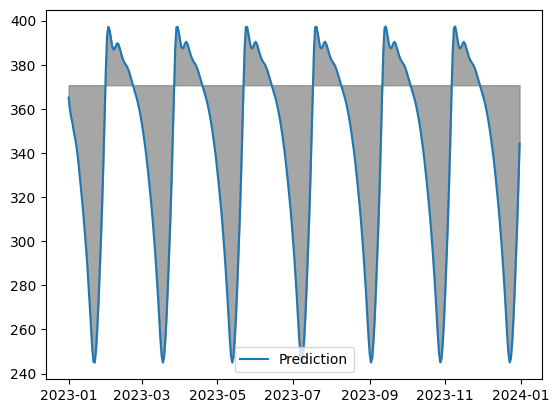

2023-01-01    365.052898
2023-01-02    359.672345
2023-01-03    356.063508
2023-01-04    353.715081
2023-01-05    350.089052
                 ...    
2023-12-27    277.150618
2023-12-28    291.545721
2023-12-29    306.865773
2023-12-30    324.263258
2023-12-31    344.331704
Freq: D, Name: value, Length: 365, dtype: float64


In [45]:

# 可视化原始数据和预测结果
# plt.plot(combined_df.index, combined_df['value'], label='Data')
plt.fill_between(predicted_df.index, data['value'][-1], predicted_df['value'], color='gray', alpha=0.7)
plt.plot(predicted_df.index, predicted_df['value'], label='Prediction')
plt.legend()
plt.show()
print(predicted_df['value'])

# 重新训练一次优化过的模型

In [52]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization
from keras.optimizers import Adam

# 加载数据
data = pd.read_excel('./energy.xls', sheet_name='Sheet2')
# 根据时间排序
data = data.sort_values(by='date')
# 将 date 列转换成 Datetime 类型，并将其设置为索引列
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# 计算去零后的均值
mean_value = data.loc[data['value'] != 0, 'value'].mean()
# 将 0 替换为去零后的均值
data['value'] = data['value'].replace(0, mean_value)

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

look_back = 20
X, y = [], []
for i in range(len(data_scaled)-look_back-1):
    a = data_scaled[i:(i+look_back), 0]
    X.append(a)
    y.append(data_scaled[i + look_back, 0])
X_train, y_train = np.array(X), np.array(y)

# 调整输入数据的形状
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# 创建LSTM模型
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), 
               activation='relu'))
model.add(BatchNormalization())
model.add(LSTM(units=32, activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
"""Sequential()：表示按照顺序构建各个神经网络层。
LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu')：表示构建一个具有64个LSTM单元的循环神经网络层，用于处理时间序列数据，同时还需要指定输入形状(X_train.shape[1], X_train.shape[2])和激活函数（此处使用的是ReLU函数），并设置返回完整的输出序列（return_sequences=True）。
BatchNormalization()：将输入数据进行标准化处理，以加速神经网络的训练过程，提高防止过拟合的能力。
LSTM(units=32, activation='relu')：构建一个具有32个LSTM单元的循环神经网络层，用于进一步处理时间序列数据。
Dense(units=1)：构建一个具有1个输出单元的全连接神经网络层，用于完成预测任务。
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')：指定模型的优化器（此处使用Adam优化器）、学习率和损失函数（此处使用均方误差损失函数）。在此之后，就可以使用model.fit()方法来训练模型，以完成预测任务。
"""

# 训练模型
model.fit(X_train, y_train, epochs=100, batch_size=32)




/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
57/57 [==============================] - 7s 92ms/step - loss: 0.0796
Epoch 2/100
57/57 [==============================] - 4s 70ms/step - loss: 0.0121
Epoch 3/100
57/57 [==============================] - 4s 74ms/step - loss: 0.0113
Epoch 4/100
57/57 [==============================] - 5s 85ms/step - loss: 0.0105
Epoch 5/100
57/57 [==============================] - 4s 69ms/step - loss: 0.0101
Epoch 6/100
57/57 [==============================] - 5s 89ms/step - loss: 0.0101
Epoch 7/100
57/57 [==============================] - 4s 67ms/step - loss: 0.0096
Epoch 8/100
57/57 [==============================] - 4s 67ms/step - loss: 0.0095
Epoch 9/100
57/57 [==============================] - 5s 87ms/step - loss: 0.0088
Epoch 10/100
57/57 [==============================] - 4s 68ms/step - loss: 0.0090
Epoch 11/100
57/57 [==============================] - 4s 66ms/step - loss: 0.0087
Epoch 12/100
57/57 [==============================] - 5s 88ms/step - loss: 0.0087
Epoch 13/100
57/57 [=====

In [80]:
# 构造未来一年的日期序列
start_date = data.index[-1] + pd.Timedelta(days=1)
end_date = start_date + pd.Timedelta(days=365)
future_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# 将历史数据进行归一化
data_scaled = scaler.transform(data)

# 构造输入数据
X_pred = []
for i in range(len(data_scaled)-look_back, len(data_scaled)):
    a = data_scaled[i:(i+look_back), 0]
    X_pred.append(a)
n_samples = len(X_pred)
max_len = max([len(el) for el in X_pred])
n_features = 1
X_pred_padded = np.zeros((n_samples, max_len, n_features))
for i, obs in enumerate(X_pred):
    X_pred_padded[i, :len(obs)] = np.squeeze(obs)
X_pred = X_pred_padded

# 预测未来一年的用电量
y_pred = model.predict(X_pred)
y_pred = scaler.inverse_transform(y_pred)

# 将预测结果与日期进行合并
future_data = pd.DataFrame({'date': future_dates, 'value': y_pred.flatten()})
future_data.set_index('date', inplace=True)

# 将历史数据与预测结果进行合并，并可视化
predicted_data = pd.concat([data, future_data])
plt.figure(figsize=(10, 5))
plt.plot(data, label='Historical data')
plt.plot(future_data, label='Predicted data')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.show()


1/1 [==============================] - 0s 40ms/step


ValueError: ignored

In [63]:
predicted = model.predict(X_train)
print(len(predicted))
predicted = scaler.inverse_transform(predicted)
print(predicted)

57/57 [==============================] - 1s 14ms/step
